## Produisez une étude de marché avec R ou Python
Vous travaillez chez La poule qui chante, une entreprise française d’agroalimentaire. Elle souhaite se développer à l'international.  <br/>  Ton objectif sera de proposer une première analyse des groupements de pays que l’on peut cibler pour exporter nos poulets. Nous approfondirons ensuite l'étude de marché.  <br/>  Tu seras en totale autonomie sur ce projet, notamment sur le choix des données à analyser et même du langage à utiliser (R ou Python).  <br/> Pars des données de la FAO (Food and Agriculture Organization) que je te mets en pièce jointe pour faire ton analyse. Si tu veux aller plus loin, notamment avec les critères de l’analyse PESTEL, tu peux récupérer et utiliser toutes les données en open data que tu souhaites sur le site de la FAO.  <br/> Pour la partie analyse, dans un premier temps j’aimerais que tu testes la classification ascendante hiérarchique, avec un dendrogramme comme visualisation. Ensuite tu pourras utiliser la méthode des k-means, afin d’affiner l’analyse et comparer les résultats des deux méthodes de clustering. N'hésite pas à prendre le temps d’analyser les centroïdes de tes classes. Tu peux également réaliser une ACP afin de visualiser les résultats de ton analyse, comprendre les groupes, les liens entre les variables, les liens entre les individus...

In [45]:
#Import des librairies Python
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn import decomposition
import warnings
warnings.filterwarnings('ignore')

### Chargement et nettoyage des données

In [5]:
aliment = pd.read_csv('DisponibiliteAlimentaire_2017.csv')
population = pd.read_csv('Population_2000_2018.csv')

In [6]:
print('Valeurs en doublon sur les données du fichier disponiblité alimentaire :'+ str(aliment.duplicated().sum()))
print('Valeurs en doublon sur les données du fichier population :'+ str(population.duplicated().sum()))

Valeurs en doublon sur les données du fichier disponiblité alimentaire :0
Valeurs en doublon sur les données du fichier population :0


In [7]:
print('Valeurs manquantes sur les données du fichier disponiblité alimentaire : ' + str(aliment.isna().any().sum()))
print('Valeurs manquantes sur les données du fichier population :'+ str(population.isna().any().sum()))

Valeurs manquantes sur les données du fichier disponiblité alimentaire : 0
Valeurs manquantes sur les données du fichier population :1


In [8]:
population.isna().any()

Code Domaine              False
Domaine                   False
Code zone                 False
Zone                      False
Code Élément              False
Élément                   False
Code Produit              False
Produit                   False
Code année                False
Année                     False
Unité                     False
Valeur                    False
Symbole                   False
Description du Symbole    False
Note                       True
dtype: bool

la variable "Note" ne sera pas utilee dans l'analyse.

In [9]:
aliment.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2511,Blé et produits,2017,2017,Milliers de tonnes,4281.0,S,Données standardisées
1,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,2302.0,S,Données standardisées
2,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2511,Blé et produits,2017,2017,Milliers de tonnes,-119.0,S,Données standardisées
3,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5911,Exportations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,0.0,S,Données standardisées
4,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5301,Disponibilité intérieure,2511,Blé et produits,2017,2017,Milliers de tonnes,6701.0,S,Données standardisées


In [10]:
aliment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176600 entries, 0 to 176599
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Code Domaine            176600 non-null  object 
 1   Domaine                 176600 non-null  object 
 2   Code zone               176600 non-null  int64  
 3   Zone                    176600 non-null  object 
 4   Code Élément            176600 non-null  int64  
 5   Élément                 176600 non-null  object 
 6   Code Produit            176600 non-null  int64  
 7   Produit                 176600 non-null  object 
 8   Code année              176600 non-null  int64  
 9   Année                   176600 non-null  int64  
 10  Unité                   176600 non-null  object 
 11  Valeur                  176600 non-null  float64
 12  Symbole                 176600 non-null  object 
 13  Description du Symbole  176600 non-null  object 
dtypes: float64(1), int64

In [11]:
aliment['Produit'].unique().tolist()

['Blé et produits',
 'Riz et produits',
 'Orge et produits',
 'Maïs et produits',
 'Seigle et produits',
 'Avoine',
 'Millet et produits',
 'Sorgho et produits',
 'Céréales, Autres',
 'Pommes de Terre et produits',
 'Ignames',
 'Racines nda',
 'Sucre, canne',
 'Sucre, betterave',
 'Sucre Eq Brut',
 'Edulcorants Autres',
 'Miel',
 'Haricots',
 'Pois',
 'Légumineuses Autres et produits',
 'Noix et produits',
 'Soja',
 'Arachides Decortiquees',
 'Graines de tournesol',
 'Graines Colza/Moutarde',
 'Graines de coton',
 'Coco (Incl Coprah)',
 'Sésame',
 'Olives',
 'Plantes Oleiferes, Autre',
 'Huile de Soja',
 "Huile d'Arachide",
 'Huile de Tournesol',
 'Huile de Colza&Moutarde',
 'Huile Graines de Coton',
 'Huile de Palmistes',
 'Huile de Palme',
 'Huile de Coco',
 'Huile de Sésame',
 "Huile d'Olive",
 'Huile de Son de Riz',
 'Huile de Germe de Maïs',
 'Huil Plantes Oleif Autr',
 'Tomates et produits',
 'Oignons',
 'Légumes, Autres',
 'Oranges, Mandarines',
 'Citrons & Limes et produits',
 

In [12]:
aliment.drop(['Code Domaine', 'Domaine', 'Code année', 'Symbole', 'Description du Symbole',
              'Code zone', 'Code Élément','Code Produit'],  axis=1, inplace=True)

In [19]:
aliment_volaille= aliment[aliment['Produit'] == 'Viande de Volailles']
aliment_volaille.sample(10)

,Zone,Élément,Produit,Année,Unité,Valeur
175371,Zambie,Disponibilité alimentaire (Kcal/personne/jour),Viande de Volailles,2017,Kcal/personne/jour,11.00
50712,Émirats arabes unis,Importations - Quantité,Viande de Volailles,2017,Milliers de tonnes,433.00
64414,Géorgie,Résidus,Viande de Volailles,2017,Milliers de tonnes,-0.00
78730,Iran (République islamique d'),Variation de stock,Viande de Volailles,2017,Milliers de tonnes,-86.00
172330,Venezuela (République bolivarienne du),Variation de stock,Viande de Volailles,2017,Milliers de tonnes,-1.00
147904,Sao Tomé-et-Principe,Disponibilité de protéines en quantité (g/pers...,Viande de Volailles,2017,g/personne/jour,3.21
97856,Luxembourg,Production,Viande de Volailles,2017,Milliers de tonnes,0.00
161486,Tchéquie,Exportations - Quantité,Viande de Volailles,2017,Milliers de tonnes,27.00
74606,Hongrie,Production,Viande de Volailles,2017,Milliers de tonnes,493.00
169316,Ukraine,Variation de stock,Viande de Volailles,2017,Milliers de tonnes,49.00


In [20]:
aliment_volaille = aliment_volaille.pivot_table(index=['Zone'], 
                                            columns='Élément', values='Valeur', aggfunc=sum).reset_index()
aliment_volaille.head()

Élément,Zone,Alimentation pour touristes,Aliments pour animaux,Autres utilisations (non alimentaire),Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Nourriture,Pertes,Production,Résidus,Semences,Traitement,Variation de stock
0,Afghanistan,NaN,NaN,NaN,5.0,1.53,0.33,0.54,57.0,NaN,29.0,55.0,2.0,28.0,0.0,NaN,NaN,0.0
1,Afrique du Sud,0.0,NaN,NaN,143.0,35.69,9.25,14.11,2118.0,63.0,514.0,2035.0,83.0,1667.0,0.0,NaN,NaN,0.0
2,Albanie,NaN,NaN,NaN,85.0,16.36,6.45,6.26,47.0,0.0,38.0,47.0,NaN,13.0,0.0,NaN,NaN,4.0
3,Algérie,0.0,NaN,NaN,22.0,6.38,1.50,1.97,277.0,0.0,2.0,264.0,13.0,275.0,0.0,NaN,NaN,0.0
4,Allemagne,NaN,NaN,NaN,71.0,19.47,4.16,7.96,1739.0,646.0,842.0,1609.0,NaN,1514.0,-38.0,NaN,167.0,-29.0


In [21]:
aliment_volaille.drop(['Alimentation pour touristes', 'Aliments pour animaux',
                       'Autres utilisations (non alimentaire)', 
    'Disponibilité alimentaire en quantité (kg/personne/an)', 
    'Disponibilité de matière grasse en quantité (g/personne/jour)','Disponibilité alimentaire (Kcal/personne/jour)',
    'Disponibilité intérieure','Nourriture','Pertes','Résidus',"Traitement",'Variation de stock','Semences'],
       axis=1, inplace=True)

In [22]:
aliment_volaille.sample(1)

Élément,Zone,Disponibilité de protéines en quantité (g/personne/jour),Exportations - Quantité,Importations - Quantité,Production
74,Jamaïque,15.71,1.0,31.0,128.0


In [23]:
aliment_volaille.rename(columns={'Disponibilité de protéines en quantité (g/personne/jour)':
                                 'dispo_protéines_volaille(g/personne/jour)'}, inplace=True)

In [24]:
aliment_volaille.shape

(172, 5)

In [25]:
population.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2000,2000,1000 personnes,20779.953,X,Sources internationales sûres,NaN
1,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2001,2001,1000 personnes,21606.988,X,Sources internationales sûres,NaN
2,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2002,2002,1000 personnes,22600.770,X,Sources internationales sûres,NaN
3,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2003,2003,1000 personnes,23680.871,X,Sources internationales sûres,NaN
4,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2004,2004,1000 personnes,24726.684,X,Sources internationales sûres,NaN


In [26]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4411 entries, 0 to 4410
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            4411 non-null   object 
 1   Domaine                 4411 non-null   object 
 2   Code zone               4411 non-null   int64  
 3   Zone                    4411 non-null   object 
 4   Code Élément            4411 non-null   int64  
 5   Élément                 4411 non-null   object 
 6   Code Produit            4411 non-null   int64  
 7   Produit                 4411 non-null   object 
 8   Code année              4411 non-null   int64  
 9   Année                   4411 non-null   int64  
 10  Unité                   4411 non-null   object 
 11  Valeur                  4411 non-null   float64
 12  Symbole                 4411 non-null   object 
 13  Description du Symbole  4411 non-null   object 
 14  Note                    258 non-null    

In [27]:
population['Valeur'] = population['Valeur']*1000

In [28]:
population_valeur=population[['Zone','Valeur','Année']]

In [29]:
population_2016 = population_valeur[population_valeur['Année'] == 2016]
population_2017 = population_valeur[population_valeur['Année'] == 2017]

In [30]:
population_pays = pd.merge(population_2016, population_2017, on='Zone')
population_pays.sample(1)

,Zone,Valeur_x,Année_x,Valeur_y,Année_y
0,Afghanistan,35383032.0,2016,36296113.0,2017


In [31]:
population_pays.rename(columns={'Valeur_x': 'Population 2016', 
                                'Valeur_y': 'Population 2017'}, inplace=True)

In [32]:
population_pays['%Evolution Population 2016/2017'] = round(((population_pays['Population 2017'] -
                                                             population_pays['Population 2016']))
                                           / population_pays['Population 2016'] *100, 2)
population_pays.head()

,Zone,Population 2016,Année_x,Population 2017,Année_y,%Evolution Population 2016/2017
0,Afghanistan,35383032.0,2016,36296113.0,2017,2.58
1,Afrique du Sud,56207646.0,2016,57009756.0,2017,1.43
2,Albanie,2886438.0,2016,2884169.0,2017,-0.08
3,Algérie,40551392.0,2016,41389189.0,2017,2.07
4,Allemagne,82193768.0,2016,82658409.0,2017,0.57


In [33]:
population_pays.sample()

,Zone,Population 2016,Année_x,Population 2017,Année_y,%Evolution Population 2016/2017
136,Maurice,1261865.0,2016,1264499.0,2017,0.21


### Ajouter sources: disponiblité proteines,PIB, stabilité politique

In [50]:
#Ajout d'une variable disponibilité proteines, Source :https://www.fao.org/faostat/fr/#data/FS
proteines = pd.read_csv('DisponiblitePoteines_2017.csv')
proteines.sample(5)

,Code Domaine,Domaine,Code zone (M49),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
129,FS,Données de la sécurité alimentaire,566,Nigéria,6123,Valeur,21013,Disponibilités protéiques moyennes (g/personne...,20162018,2016-2018,g/personne/jour,60.0,E,Valeur estimée,NaN
99,FS,Données de la sécurité alimentaire,296,Kiribati,6123,Valeur,21013,Disponibilités protéiques moyennes (g/personne...,20162018,2016-2018,g/personne/jour,71.0,E,Valeur estimée,NaN
125,FS,Données de la sécurité alimentaire,520,Nauru,6123,Valeur,21013,Disponibilités protéiques moyennes (g/personne...,20162018,2016-2018,g/personne/jour,NaN,O,Valeur manquante,NaN
178,FS,Données de la sécurité alimentaire,728,Soudan du Sud,6123,Valeur,21013,Disponibilités protéiques moyennes (g/personne...,20162018,2016-2018,g/personne/jour,NaN,O,Valeur manquante,NaN
120,FS,Données de la sécurité alimentaire,496,Mongolie,6123,Valeur,21013,Disponibilités protéiques moyennes (g/personne...,20162018,2016-2018,g/personne/jour,93.7,E,Valeur estimée,NaN


In [51]:
proteines.drop(['Code Domaine', 'Domaine', 'Code zone (M49)', 'Symbole', 'Description du Symbole',
                'Code Élément','Code Produit','Élément',"Code année",'Année','Note'],  axis=1, inplace=True)

In [52]:
proteines.sample(1)

,Zone,Produit,Unité,Valeur
183,Tadjikistan,Disponibilités protéiques moyennes (g/personne...,g/personne/jour,69.7


In [53]:
dispo_proteines= proteines.pivot_table(index=['Zone'], 
                                            columns='Produit', values='Valeur', aggfunc=sum).reset_index()
dispo_proteines.sample(3)

Produit,Zone,Disponibilités protéiques moyennes (g/personne/jour) (moyenne sur 3 ans)
137,Polynésie française,95.3
75,Hongrie,88.0
25,Brunéi Darussalam,0.0


In [54]:
print('Valeurs en doublon sur les données du fichier disponiblité proteines :'+ 
                                                              str(dispo_proteines.duplicated().sum()))

Valeurs en doublon sur les données du fichier disponiblité proteines :0


In [55]:
print('Valeurs manquantes sur les données du fichier disponiblité proteines: ' + 
                                                              str(dispo_proteines.isna().any().sum()))

Valeurs manquantes sur les données du fichier disponiblité proteines: 0


In [56]:
dispo_proteines.shape

(204, 2)

In [57]:
df1 = pd.merge(aliment_volaille, population_pays[['Zone', '%Evolution Population 2016/2017','Population 2017']], 
               on='Zone',how='right')
df1.head(3)

,Zone,dispo_protéines_volaille(g/personne/jour),Exportations - Quantité,Importations - Quantité,Production,%Evolution Population 2016/2017,Population 2017
0,Afghanistan,0.54,NaN,29.0,28.0,2.58,36296113.0
1,Afrique du Sud,14.11,63.0,514.0,1667.0,1.43,57009756.0
2,Albanie,6.26,0.0,38.0,13.0,-0.08,2884169.0


In [58]:
df2 = pd.merge(df1,dispo_proteines, on="Zone", how='left')
df2.head(3)

,Zone,dispo_protéines_volaille(g/personne/jour),Exportations - Quantité,Importations - Quantité,Production,%Evolution Population 2016/2017,Population 2017,Disponibilités protéiques moyennes (g/personne/jour) (moyenne sur 3 ans)
0,Afghanistan,0.54,NaN,29.0,28.0,2.58,36296113.0,58.0
1,Afrique du Sud,14.11,63.0,514.0,1667.0,1.43,57009756.0,79.7
2,Albanie,6.26,0.0,38.0,13.0,-0.08,2884169.0,113.3


In [59]:
PIB = pd.read_csv('PIB.csv')
PIB.head(2)

,Code Domaine,Domaine,Code zone (M49),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,FS,Données de la sécurité alimentaire,4,Afghanistan,6126,Valeur,22013,"PIB par habitant, ($ PPA internationaux consta...",2017,2017,I$,2058.4,X,Ciffre de sources internationales,NaN
1,FS,Données de la sécurité alimentaire,710,Afrique du Sud,6126,Valeur,22013,"PIB par habitant, ($ PPA internationaux consta...",2017,2017,I$,13860.3,X,Ciffre de sources internationales,NaN


In [60]:
df_pib=PIB[['Zone','Valeur']]
df_pib.sample(1)

,Zone,Valeur
92,Kiribati,2069.1


In [61]:
df_pib.rename(columns = {'Valeur':'PIB/habitant US$'}, inplace = True)

In [62]:
df_pib.shape

(187, 2)

In [63]:
df3=pd.merge(df2, df_pib, on='Zone', how='left')
df3.head(5)

,Zone,dispo_protéines_volaille(g/personne/jour),Exportations - Quantité,Importations - Quantité,Production,%Evolution Population 2016/2017,Population 2017,Disponibilités protéiques moyennes (g/personne/jour) (moyenne sur 3 ans),PIB/habitant US$
0,Afghanistan,0.54,NaN,29.0,28.0,2.58,36296113.0,58.0,2058.4
1,Afrique du Sud,14.11,63.0,514.0,1667.0,1.43,57009756.0,79.7,13860.3
2,Albanie,6.26,0.0,38.0,13.0,-0.08,2884169.0,113.3,12771.0
3,Algérie,1.97,0.0,2.0,275.0,2.07,41389189.0,89.3,11737.4
4,Allemagne,7.96,646.0,842.0,1514.0,0.57,82658409.0,104.3,53071.5


In [64]:
stabilité_politique=pd.read_csv('stability_politique.csv')
stabilité_politique.sample()

,Code Domaine,Domaine,Code zone (M49),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
156,FS,Données de la sécurité alimentaire,646,Rwanda,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2017,2017,indice,0.09,X,Ciffre de sources internationales,NaN


In [65]:
stabilité_politique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            197 non-null    object 
 1   Domaine                 197 non-null    object 
 2   Code zone (M49)         197 non-null    int64  
 3   Zone                    197 non-null    object 
 4   Code Élément            197 non-null    int64  
 5   Élément                 197 non-null    object 
 6   Code Produit            197 non-null    int64  
 7   Produit                 197 non-null    object 
 8   Code année              197 non-null    int64  
 9   Année                   197 non-null    int64  
 10  Unité                   197 non-null    object 
 11  Valeur                  197 non-null    float64
 12  Symbole                 197 non-null    object 
 13  Description du Symbole  197 non-null    object 
 14  Note                    0 non-null      fl

In [66]:
print('Valeurs en doublon sur les données du fichier stabilité politique :'+ 
                                                              str(stabilité_politique.duplicated().sum()))

Valeurs en doublon sur les données du fichier stabilité politique :0


In [67]:
print('Valeurs manquantes sur les données du fichier stablité politique: ' + 
                                                              str(stabilité_politique.isna().any().sum()))

Valeurs manquantes sur les données du fichier stablité politique: 1


In [68]:
stabilité_politique.isna().any()

Code Domaine              False
Domaine                   False
Code zone (M49)           False
Zone                      False
Code Élément              False
Élément                   False
Code Produit              False
Produit                   False
Code année                False
Année                     False
Unité                     False
Valeur                    False
Symbole                   False
Description du Symbole    False
Note                       True
dtype: bool

In [69]:
stabilité_politique.drop(['Code Domaine', 'Domaine', 'Code zone (M49)','Unité', 'Symbole','Description du Symbole',
      'Note','Code Élément','Code Produit','Élément',"Code année",'Année','Note','Produit'],  axis=1, inplace=True)
stabilité_politique.sample(1)

,Zone,Valeur
147,République de Corée,0.39


In [70]:
stabilité_politique.rename(columns={'Valeur': 'Stabilité politique'}, inplace=True)

In [71]:
df=pd.merge(df3, stabilité_politique, on='Zone', how='left')
df.sample(5)

,Zone,dispo_protéines_volaille(g/personne/jour),Exportations - Quantité,Importations - Quantité,Production,%Evolution Population 2016/2017,Population 2017,Disponibilités protéiques moyennes (g/personne/jour) (moyenne sur 3 ans),PIB/habitant US$,Stabilité politique
163,Panama,10.34,0.0,20.0,198.0,1.73,4106769.0,82.1,30446.8,0.39
80,Guam,NaN,NaN,NaN,NaN,0.82,164281.0,NaN,NaN,NaN
200,Sénégal,1.61,0.0,0.0,77.0,2.84,15419355.0,63.0,3203.9,-0.05
190,Sainte-Lucie,19.00,NaN,10.0,1.0,0.52,180954.0,0.0,14928.4,0.99
171,Porto Rico,NaN,NaN,NaN,NaN,-3.64,3163667.0,0.0,34363.8,0.48


### Traitement valeur NaN

In [73]:
# % valeurs manquantes par colonne, on ne prendra pas en compte le variable +40% valeurs manquantes
df.isna().mean()

Zone                                                                        0.000000
dispo_protéines_volaille(g/personne/jour)                                   0.271186
Exportations - Quantité                                                     0.427966
Importations - Quantité                                                     0.279661
Production                                                                  0.288136
%Evolution Population 2016/2017                                             0.000000
Population 2017                                                             0.000000
Disponibilités protéiques moyennes (g/personne/jour) (moyenne sur 3 ans)    0.144068
PIB/habitant US$                                                            0.216102
Stabilité politique                                                         0.169492
dtype: float64

In [74]:
df.drop(['Exportations - Quantité'],  axis=1, inplace=True)

In [75]:
df.describe()

,dispo_protéines_volaille(g/personne/jour),Importations - Quantité,Production,%Evolution Population 2016/2017,Population 2017,Disponibilités protéiques moyennes (g/personne/jour) (moyenne sur 3 ans),PIB/habitant US$,Stabilité politique
count,172.000000,170.000000,168.000000,236.000000,2.360000e+02,202.000000,185.000000,196.000000
mean,7.121279,89.529412,725.190476,1.184110,3.198362e+07,66.332673,20775.293514,-0.066786
std,5.603464,186.669983,2501.457125,1.229585,1.318949e+08,36.994636,22057.116752,0.994869
min,0.040000,0.000000,0.000000,-3.640000,7.930000e+02,0.000000,773.600000,-2.940000
25%,2.165000,3.000000,13.750000,0.370000,3.803032e+05,53.850000,4830.800000,-0.655000
50%,6.505000,16.000000,70.000000,1.075000,5.203510e+06,72.650000,12973.800000,0.035000
75%,10.365000,81.250000,409.750000,2.002500,1.930842e+07,92.000000,28673.600000,0.755000
max,27.870000,1069.000000,21914.000000,4.790000,1.421022e+09,143.000000,126144.000000,1.920000


### Les outliers

<Axes: >

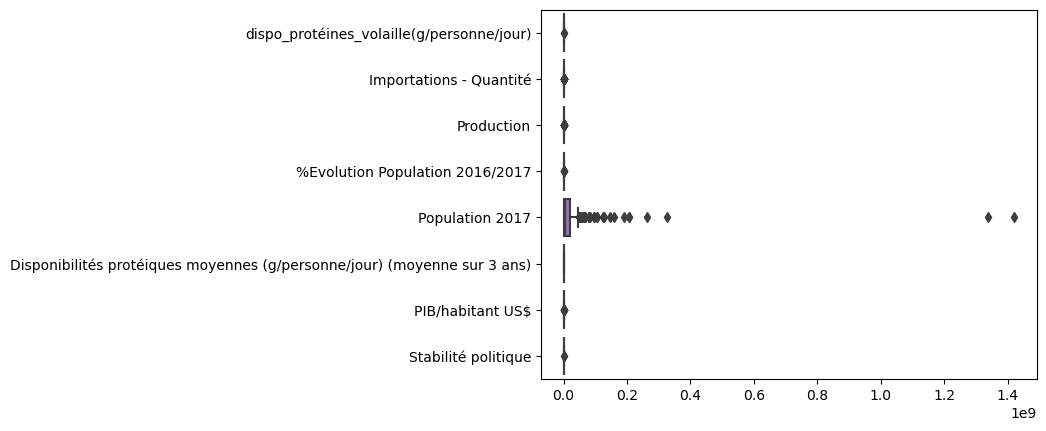

In [78]:
sns.boxplot(df,orient= 'h')

In [79]:
df.sort_values(by='Production', ascending=False).head(10)

,Zone,dispo_protéines_volaille(g/personne/jour),Importations - Quantité,Production,%Evolution Population 2016/2017,Population 2017,Disponibilités protéiques moyennes (g/personne/jour) (moyenne sur 3 ans),PIB/habitant US$,Stabilité politique
65,États-Unis d'Amérique,19.93,123.0,21914.0,0.64,3.250848e+08,113.3,59914.8,0.29
43,"Chine, continentale",3.96,452.0,18236.0,0.49,1.421022e+09,103.7,NaN,NaN
31,Brésil,15.68,3.0,14201.0,0.81,2.078338e+08,94.3,14524.6,-0.47
67,Fédération de Russie,10.44,226.0,4444.0,0.18,1.455301e+08,102.0,25926.4,-0.64
103,Inde,0.75,0.0,3545.0,1.07,1.338677e+09,64.0,6182.9,-0.76
139,Mexique,9.26,972.0,3249.0,1.17,1.247773e+08,90.0,19721.3,-0.80
169,Pologne,12.14,55.0,2351.0,-0.09,3.795318e+07,104.3,30064.5,0.52
104,Indonésie,2.42,1.0,2301.0,1.18,2.646510e+08,68.0,10935.6,-0.50
112,Japon,7.24,1069.0,2215.0,-0.20,1.275027e+08,86.0,41444.2,1.11
226,Turquie,6.99,3.0,2192.0,1.61,8.111645e+07,109.3,27913.8,-1.79


Les trois plus gros producteurs de volaille sont les États-Unis, la Chine et le Brésil, en termes de volumes produits.

In [80]:
df.sort_values(by='Population 2017', ascending=False).head(10)

,Zone,dispo_protéines_volaille(g/personne/jour),Importations - Quantité,Production,%Evolution Population 2016/2017,Population 2017,Disponibilités protéiques moyennes (g/personne/jour) (moyenne sur 3 ans),PIB/habitant US$,Stabilité politique
43,"Chine, continentale",3.96,452.0,18236.0,0.49,1.421022e+09,103.7,NaN,NaN
103,Inde,0.75,0.0,3545.0,1.07,1.338677e+09,64.0,6182.9,-0.76
65,États-Unis d'Amérique,19.93,123.0,21914.0,0.64,3.250848e+08,113.3,59914.8,0.29
104,Indonésie,2.42,1.0,2301.0,1.18,2.646510e+08,68.0,10935.6,-0.50
160,Pakistan,1.97,2.0,1281.0,2.10,2.079062e+08,65.7,5091.1,-2.41
31,Brésil,15.68,3.0,14201.0,0.81,2.078338e+08,94.3,14524.6,-0.47
152,Nigéria,0.31,0.0,201.0,2.64,1.908732e+08,60.0,5190.4,-2.00
19,Bangladesh,0.47,0.0,249.0,1.08,1.596854e+08,59.0,4894.6,-1.26
67,Fédération de Russie,10.44,226.0,4444.0,0.18,1.455301e+08,102.0,25926.4,-0.64
112,Japon,7.24,1069.0,2215.0,-0.20,1.275027e+08,86.0,41444.2,1.11


Les pays les plus peuplés sont la Chine, l'Inde et les États-Unis, en termes de population.

In [81]:
df.sort_values(by='PIB/habitant US$', ascending=False).head(10)

,Zone,dispo_protéines_volaille(g/personne/jour),Importations - Quantité,Production,%Evolution Population 2016/2017,Population 2017,Disponibilités protéiques moyennes (g/personne/jour) (moyenne sur 3 ans),PIB/habitant US$,Stabilité politique
42,Chine - RAS de Macao,11.90,23.0,3.0,1.59,622585.0,106.7,126144.0,1.43
126,Luxembourg,7.19,11.0,0.0,2.18,591910.0,109.3,114986.0,1.33
204,Singapour,NaN,NaN,NaN,0.96,5708041.0,0.0,95310.3,1.62
173,Qatar,NaN,NaN,NaN,2.65,2724728.0,0.0,91738.8,0.66
25,Bermudes,NaN,NaN,NaN,-0.49,63049.0,0.0,81835.0,1.00
107,Irlande,11.60,99.0,110.0,1.22,4753279.0,114.4,77749.2,1.00
213,Suisse,6.49,51.0,91.0,0.91,8455804.0,96.3,69103.6,1.26
59,Émirats arabes unis,14.80,433.0,48.0,1.35,9487203.0,82.0,67183.6,0.62
154,Norvège,7.81,2.0,101.0,0.86,5296326.0,113.7,64050.8,1.17
32,Brunéi Darussalam,NaN,NaN,NaN,1.11,424473.0,0.0,60994.5,1.16


Conforme au classement des pays en termes de PIB par habitant.

In [82]:
df.to_csv('df.csv',index=False)